# Common Voice Dataset Training with Whisper

This notebook demonstrates how to train or fine-tune the Whisper model using the Common Voice dataset.

In [10]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from src.config.hyperparameters import Hyperparameters
from src.models.whisper.model import WhisperModel
from src.utils.common_voice import process_common_voice_metadata

## Set up paths and configuration

In [11]:
# Set paths for Common Voice dataset
common_voice_dir = 'data/cv-corpus-21.0-delta-2025-03-14/en'

# Available TSV files
validated_tsv = os.path.join(common_voice_dir, 'validated.tsv')
validated_sentences_tsv = os.path.join(common_voice_dir, 'validated_sentences.tsv')
unvalidated_sentences_tsv = os.path.join(common_voice_dir, 'unvalidated_sentences.tsv')
clip_durations_tsv = os.path.join(common_voice_dir, 'clip_durations.tsv')
invalidated_tsv = os.path.join(common_voice_dir, 'invalidated.tsv')
other_tsv = os.path.join(common_voice_dir, 'other.tsv')
reported_tsv = os.path.join(common_voice_dir, 'reported.tsv')

# Ensure the clips directory exists
clips_dir = os.path.join(common_voice_dir, 'clips')
os.makedirs(clips_dir, exist_ok=True)

# Initialize hyperparameters
hyperparameters = Hyperparameters()
hyperparameters.learning_rate = 0.8
hyperparameters.batch_size = 2
hyperparameters.num_epochs = 30

In [12]:
# Create /generated/
generated_dir = os.path.join(common_voice_dir, 'generated')
os.makedirs(generated_dir, exist_ok=True)

# Process validated data and create splits
if os.path.exists(validated_tsv):
    # Load the validated data
    validated_df = pd.read_csv(validated_tsv, sep='\t')
    print(f"Number of validated samples: {len(validated_df)}")
    print("Preview of validated data:")
    display(validated_df.head())
    
    # Create train/validation/test splits (80/10/10)
    train_df, temp_df = train_test_split(validated_df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Save the splits to TSV files for easier loading
    train_df.to_csv(os.path.join(generated_dir, 'train_split.tsv'), sep='\t', index=False)
    val_df.to_csv(os.path.join(generated_dir, 'dev_split.tsv'), sep='\t', index=False)
    test_df.to_csv(os.path.join(generated_dir, 'test_split.tsv'), sep='\t', index=False)
else:
    print(f"Warning: {validated_tsv} does not exist. Please download the Common Voice dataset.")

Number of validated samples: 249
Preview of validated data:


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,116398939d6be70fc5fb532924a130c0adf286ac283499...,common_voice_en_41923025.mp3,f5a2a431746c5229ab696ba0e1a518fe7b26e208ff3b84...,"He was born at Wichenford, in Worcestershire, ...",NaN,2,0,thirties,NaN,United States English,NaN,en,NaN
1,24a4da2e8f053a45a0715849c222a40a4b0da9872efb2e...,common_voice_en_42356358.mp3,f6f009587d8812c147af1cc05079e1fcd8120c8a98cdf8...,The Portuguese division was overrun and withdr...,NaN,2,0,teens,NaN,United States English,NaN,en,NaN
2,30849595699bc853c3810a78448acede46888b4e2d0809...,common_voice_en_42165090.mp3,f69afa5e77812e8be0085c874d2a9767323c78ffb43ba6...,Her health by this stage was also poor.,NaN,2,0,NaN,NaN,NaN,NaN,en,NaN
3,42d53f34c1bc50f7a7c4ed1765a8d1ffeaf5cd441513cc...,common_voice_en_41921729.mp3,f5739acbefdbd3aac990792966fac4d40dcb39eb8dfa21...,His sporting interests outside of cricket incl...,NaN,2,0,nineties,NaN,England English,NaN,en,NaN
4,436b9e1f9da710d74eb01209f8f269bee70e93cadf2053...,common_voice_en_42528393.mp3,f7d35c60d76f025c45a9495757d1ee0e2b7c206317a288...,The following year he was elected to be part o...,NaN,2,0,teens,NaN,United States English,NaN,en,NaN


Training samples: 199
Validation samples: 25
Test samples: 25


## Check audio durations

Total clips with duration info: 21796
Statistics on clip durations:


,duration[ms]
count,21796.000000
mean,6406.219490
std,3388.725049
min,1152.000000
25%,4968.000000
50%,6120.000000
75%,7488.000000
max,233820.000000


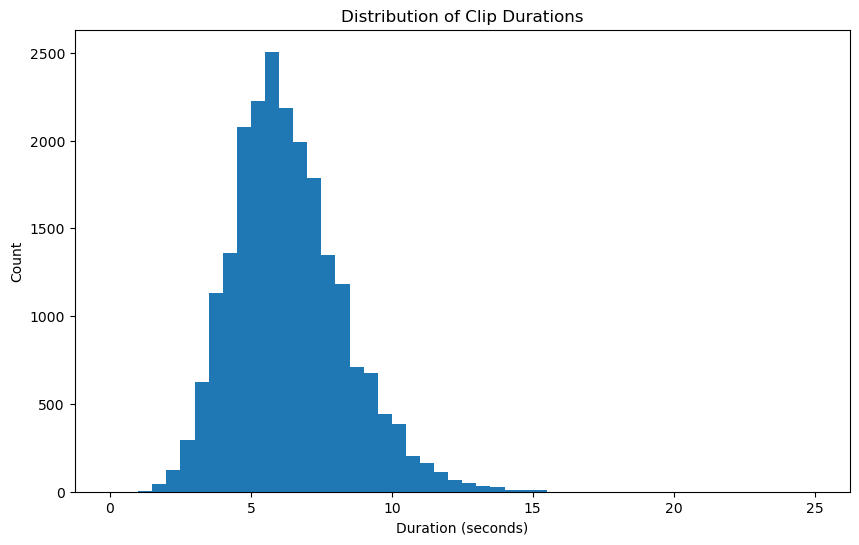

In [13]:
# Examine clip durations if available
if os.path.exists(clip_durations_tsv):
    durations_df = pd.read_csv(clip_durations_tsv, sep='\t')
    print(f"Total clips with duration info: {len(durations_df)}")
    print("Statistics on clip durations:")
    display(durations_df.describe())
    
    # Plot duration histogram
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.hist(durations_df['duration[ms]'] / 1000, bins=50, range=(0, 25))
        plt.title('Distribution of Clip Durations')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Count')
        plt.show()
    except Exception as e:
        print(f"Could not create plot: {e}")
else:
    print(f"Warning: {clip_durations_tsv} does not exist.")

In [14]:
# Simple custom trainer for our specific dataset format
class CustomVoiceTrainer:
    def __init__(self, model, common_voice_dir, hyperparameters):
        self.model = model
        self.common_voice_dir = common_voice_dir
        self.hyperparameters = hyperparameters
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def load_split(self, split_name):
        """Load a dataset split from the custom created files"""
        split_path = os.path.join(self.common_voice_dir, f'generated/{split_name}_split.tsv')
        if not os.path.exists(split_path):
            raise FileNotFoundError(f"Split file {split_path} not found")
            
        from torch.utils.data import Dataset
        
        class VoiceDataset(Dataset):
            def __init__(self, tsv_file, clips_dir):
                self.df = pd.read_csv(tsv_file, sep='\t')
                self.clips_dir = clips_dir
                
            def __len__(self):
                return len(self.df)
                
            def __getitem__(self, idx):
                row = self.df.iloc[idx]
                clip_path = os.path.join(self.clips_dir, row['path'])
                # You'll need to implement actual audio loading based on your file format
                from src.utils.audio import load_audio
                audio, _ = load_audio(clip_path)
                return {
                    'audio': audio,
                    'text': row['sentence'],
                    'path': clip_path
                }
        
        return VoiceDataset(split_path, os.path.join(self.common_voice_dir, 'clips'))
    
    def train(self, epochs=3):
        """Train the model using the custom splits"""
        from torch.utils.data import DataLoader
        
        # Load datasets
        try:
            train_dataset = self.load_split('train')
            val_dataset = self.load_split('dev')
            
            train_loader = DataLoader(train_dataset, batch_size=self.hyperparameters.batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=self.hyperparameters.batch_size)
            
            print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples")
            print(f"Using device: {self.device}")
            
            # Simple training loop sketch - this would need to be implemented
            # specific to your WhisperModel's training functionality
            for epoch in range(epochs):
                print(f"Epoch {epoch+1}/{epochs}")
                # Training code would go here
                
            return self.model
            
        except Exception as e:
            print(f"Error during training setup: {e}")
            return None

## Train the model with custom data

In [15]:
# Initialize whisper model
whisper_model = WhisperModel(hyperparameters)

# Initialize custom trainer
trainer = CustomVoiceTrainer(
    model=whisper_model,
    common_voice_dir=common_voice_dir,
    hyperparameters=hyperparameters
)

# Train with our custom data format
try:
    trained_model = trainer.train(epochs=hyperparameters.num_epochs)
    print("Training complete!")
except Exception as e:
    print(f"Error during training: {e}")

c:\Users\PC\.conda\envs\voxlens_stt\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)

Training on 199 samples, validating on 25 samples
Using device: cpu
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Training complete!


## Evaluate the trained model

In [16]:
# Load test dataset
from src.utils.common_voice import load_common_voice_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import numpy as np

def collate_fn(batch):
    # Ensure that 'audio' is a tensor
    for sample in batch:
        if isinstance(sample['audio'], np.ndarray):
            sample['audio'] = torch.tensor(sample['audio'])
    
    # Get the maximum length of the audio tensors in the batch
    max_len = max([sample['audio'].size(0) for sample in batch])
    
    # Pad the audio tensors to the maximum length
    padded_audio = torch.stack([
        F.pad(sample['audio'], (0, max_len - sample['audio'].size(0))) for sample in batch
    ])
    
    # Handle text data
    text = [sample['text'] for sample in batch]
    return {'audio': padded_audio, 'text': text}

test_dataset = load_common_voice_dataset(common_voice_dir, split='generated/test_split')

# Use the custom collate function in the DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)

# Ensure proper handling of audio data during transcription
for i, sample in enumerate(test_loader):
    if i >= 3:  # Only test first 3 batches
        break

    audio = sample['audio'].to(trainer.device)  # Move audio to the correct device
    reference_text = sample['text']
    
    # Transcribe audio
    try:
        transcribed_text = trained_model.transcribe(audio)
        print(f"Example {i+1}")
        print(f"Reference: {reference_text}")
        print(f"Transcription: {transcribed_text}")
    except Exception as e:
        print(f"Error during transcription: {e}")
    print("-" * 50)

c:\Users\PC\.conda\envs\voxlens_stt\Lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Example 1
Reference: ['If anything, I was more competent in handling physical affairs.', 'He won his first career race at New Hampshire and finished eighth in points.', 'The group then sing the bridge, and end the song repeating the chorus twice.', 'Typically it encloses a metal grommet for reinforcement and to reduce wear.', 'He later commented that he did not support the death of Norwegian military personnel.', 'Currently, it also houses the American Airpower Museum.', 'According to an old account, there was an important exception to the rule.', 'A disjunct subset of its range occurs from central Colorado to northwestern New Mexico.', 'With that task accomplished he felt he could retire at a high point.', 'The ghettoization was completed within a week.', "He attended Iowa State University, where he played defense on the school's football team.", 'He is quickly killed by Superboy-Prime amidst the chaos.', 'The competition is open to young skippers across all classes.', 'I leave my nec